In [1]:
library(lme4)
library(simr)
library(dplyr)
library(broom)
install.packages("sjPlot")
library(sjPlot)
install.packages("broom.mixed")
library(broom.mixed)
library(htmlTable)
library(dplyr)
library(stringr)
# library(gt)
library(car)
install.packages("stargazer")
library(stargazer)
# First install and load lmerTest
install.packages("lmerTest")
library(lmerTest)

Loading required package: Matrix


Attaching package: ‘simr’


The following object is masked from ‘package:lme4’:

    getData



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





The downloaded binary packages are in
	/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T//Rtmpytjv8K/downloaded_packages

The downloaded binary packages are in
	/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T//Rtmpytjv8K/downloaded_packages



Attaching package: ‘stringr’


The following object is masked from ‘package:simr’:

    fixed


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode





The downloaded binary packages are in
	/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T//Rtmpytjv8K/downloaded_packages



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 





The downloaded binary packages are in
	/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T//Rtmpytjv8K/downloaded_packages



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




In [2]:
# pilot_total_stats - no mean centering, just spliting pos neg on z scored similarities
# pilot_total_centered_stats - With mean centering but also z scoring before splitting 
#pilot_total_centered_noz_stats - with mean centering and not z scoring for pos neg split
# pilot_total_centered_noz_stats - with mean centering similarities before pos neg split and using those
# in sign flipped etc. versions

file_path_total <- 'pilot_total_stats/correct_wm_ltm.csv'
file_path_5 <- 'pilot5_stats/correct_wm_ltm.csv'
file_path_6 <- 'pilot6_stats/correct_wm_ltm.csv'

df_total <- read.csv(file_path_total) 
df5 <- read.csv(file_path_5) 
df6 <- read.csv(file_path_6) 
# %>%
#     select(it_sim_dis_diff, it_sim_dis_diff_sq, reliability, v2_sim_dis_diff, v2_sim_dis_diff_sq, participant, validity, resp_correct, Accuracy, validity_binary, reliability_binary, v2_sim_dis_attend, v2_sim_dis_attend_z, v2_sim_dis_attend_sq_z, it_sim_dis_attend, it_sim_dis_attend_z, it_sim_dis_attend_sq_z, v2_sim_dis_unattend, v2_sim_dis_unattend_z, v2_sim_dis_unattend_sq_z, it_sim_dis_unattend, it_sim_dis_unattend_z, it_sim_dis_unattend_sq_z, it_sim_dis_diff_z, v2_sim_dis_diff_z,it_sim_dis_diff_sq_z, v2_sim_dis_diff_sq_z )

In [3]:
control <- lmerControl(optimizer = "bobyqa")#, optCtrl = list(maxfun = 10000))

In [4]:
df <- df_total

In [11]:
run_ltm_models <- function(df) {
    
#     cols_to_scale <- c("reliability_binary", "attend_binary", "tested_binary", 
#                   "it_ltm", "it_ltm_sq", "v2_ltm", "v2_ltm_sq",
#                    "it_ltm_diff", "it_ltm_diff_sq","v2_ltm_diff", "v2_ltm_diff_sq", 
#                       "it_ltm_diff_sign", "it_ltm_diff_sign_sq","v2_ltm_diff_sign", "v2_ltm_diff_sign_sq")

# # Use lapply to apply the scale function to each column and create new columns
#     df[paste0(cols_to_scale, "_z")] <- lapply(df[cols_to_scale], scale)
    
    ltm_abs <- glmer(recall_answ ~ (it_ltm_z + it_ltm_sq_z)  * reliability_binary_z *  
                      attend_binary_z + (v2_ltm_z + v2_ltm_sq_z) * reliability_binary_z *  
                      attend_binary_z + tested_binary_z + (1 | participant), 
                      data = df, family = binomial,control = glmerControl(optimizer = "bobyqa",
                                            optCtrl = list(maxfun = 500000),
                                            calc.derivs = FALSE))
    ltm_rel <- glmer(recall_answ ~ (it_ltm_diff_z + it_ltm_diff_sq_z)  * reliability_binary_z *  
                      attend_binary_z + (v2_ltm_diff_z + v2_ltm_diff_sq_z) * reliability_binary_z *  
                      attend_binary_z + tested_binary_z + (1 | participant), 
                      data = df, family = binomial,control = glmerControl(optimizer = "bobyqa",
                                            optCtrl = list(maxfun = 500000),
                                            calc.derivs = FALSE))
    ltm_rel_split <- glmer(recall_answ ~ (it_ltm_diff_sign_z + it_ltm_diff_sign_sq_z) * it_pos_neg_ltm * reliability_binary_z *  
                      attend_binary_z + (v2_ltm_diff_sign_z + v2_ltm_diff_sign_sq_z) * v2_pos_neg_ltm * reliability_binary_z *  
                      attend_binary_z + tested_binary_z + (1 | participant), 
                      data = df, family = binomial,control = glmerControl(optimizer = "bobyqa",
                                            optCtrl = list(maxfun = 500000),
                                            calc.derivs = FALSE))
     return(list(
    ltm_abs       = ltm_abs,
    ltm_rel       = ltm_rel,
    ltm_rel_split = ltm_rel_split

  ))
}

In [12]:
results_old_stims <- run_ltm_models(df6)



In [13]:
results_new_stims <- run_ltm_models(df5)
results_total <- run_ltm_models(df_total)


In [14]:
extract_significance <- function(model_summary) {
  # For glmer models
  if ("coefficients" %in% names(model_summary)) {
    # Check more carefully for z value vs t value columns
    coef_table <- model_summary$coefficients
    var_names <- rownames(coef_table)
    
    # Check which p-value column exists
    if ("Pr(>|z|)" %in% colnames(coef_table)) {
      p_values <- coef_table[, "Pr(>|z|)"]
    } else if ("Pr(>|t|)" %in% colnames(coef_table)) {
      p_values <- coef_table[, "Pr(>|t|)"]
    } else {
      # If there's a z or t value, calculate p-values manually
      if ("z value" %in% colnames(coef_table)) {
        z_values <- coef_table[, "z value"]
        p_values <- 2 * pnorm(abs(z_values), lower.tail = FALSE)
      } else if ("t value" %in% colnames(coef_table)) {
        t_values <- coef_table[, "t value"]
        # Using a large df for approximation
        p_values <- 2 * pt(abs(t_values), df = 100, lower.tail = FALSE)
      } else {
        stop("Cannot find p-values or z/t values in coefficients table")
      }
    }
  } else {
    # More detailed debug info
    cat("Available names in model summary:\n")
    print(names(model_summary))
    
    # Try to access fixed effects via other means
    if ("fixed.effects" %in% names(model_summary)) {
      var_names <- names(model_summary$fixed.effects)
      # Manually calculate p-values using fixed effects and std errors
      # This is just a placeholder - would need to be adapted to actual structure
      stop("Found fixed.effects but need appropriate calculation of p-values")
    } else {
      stop("Could not extract coefficients from model summary")
    }
  }
  
  # Calculate significance stars
  significance <- sapply(p_values, function(p) {
    if (is.na(p)) return("")
    if (p < 0.001) return("***")
    if (p < 0.01) return("**")
    if (p < 0.05) return("*")
    if (p < 0.1) return(".")
    return("")
  })
  
  return(data.frame(
    variable = var_names,
    p_value = p_values,
    significance = significance,
    stringsAsFactors = FALSE
  ))
}


In [15]:
compare_models <- function(model_list, model_names, 
                          include_p_values = FALSE,
                          only_significant = TRUE,
                          significance_level = 0.1) {
  
  sig_list <- lapply(model_list, extract_significance)
  names(sig_list) <- model_names
  
  all_vars <- unique(unlist(lapply(sig_list, function(x) x$variable)))
  
  result_df <- data.frame(Variable = all_vars, stringsAsFactors = FALSE)
  
  # First, determine which rows have significance in any model
  has_significance_by_var <- sapply(all_vars, function(var) {
    any_significant <- FALSE
    for(model_name in model_names) {
      model_sig <- sig_list[[model_name]]
      idx <- which(model_sig$variable == var)
      if(length(idx) > 0) {
        stars <- model_sig$significance[idx]
        if(stars != "") {
          any_significant <- TRUE
          break
        }
      }
    }
    return(any_significant)
  })
  
  # Now populate the data frame with all p-values for rows with any significance
  for(model_name in model_names) {
    model_sig <- sig_list[[model_name]]
    result_df[[model_name]] <- sapply(all_vars, function(var) {
      idx <- which(model_sig$variable == var)
      if(length(idx) == 0) return("")
      
      p_val <- model_sig$p_value[idx]
      stars <- model_sig$significance[idx]
      
      # Always show p-value if this variable has significance in any model
      if(has_significance_by_var[var] || !only_significant) {
        return(paste0(stars, " (p=", sprintf("%.4f", p_val), ")"))
      } else if(stars != "") {
        # Show significance stars with p-value for significant results
        return(paste0(stars, " (p=", sprintf("%.4f", p_val), ")"))
      } else {
        # For non-significant results in rows without any significance
        return("")
      }
    })
  }
  
  # Filter rows if only_significant is TRUE
  if(only_significant) {
    result_df <- result_df[has_significance_by_var, ]
  }
  
  # Adjust HTML table styling to make first column wider
  html_table <- htmlTable(
    result_df,
    caption = "Significance Comparison Across Models",
    rnames = FALSE,
    css.cell = "padding: 8px;",
    css.table = "border-collapse: collapse; width: 100%; font-family: Arial, sans-serif;",
    css.header = "background-color: #f2f2f2; font-weight: bold; border: 1px solid #dddddd;",
    css.rgroup = "border-bottom: 1px solid #dddddd;",
    css.tspanner = "font-weight: bold; text-align: center; border-bottom: 2px solid #dddddd;",
    css.class = "table-hover"
  )
  
  # Add additional CSS to make the first column wider
  html_table <- gsub("<table", "<style>td:first-child, th:first-child { min-width: 300px; max-width: 500px; word-wrap: break-word; }</style><table", html_table)
  
  return(html_table)
}

In [16]:
ltm_abs_old <- summary(results_old_stims$ltm_abs)
ltm_abs_new <- summary(results_new_stims$ltm_abs)
ltm_abs_total <- summary(results_total$ltm_abs)

comparison_table_abs <- compare_models(
  model_list = list(ltm_abs_old, ltm_abs_new, ltm_abs_total),
  model_names = c("Old Stimuli", "New Stimuli", "Total"),
  include_p_values = TRUE,  # Change to FALSE for just stars
  only_significant = TRUE
)

# Save to HTML file for inclusion in presentations
writeLines(comparison_table_abs, "comparison_table_abs_cent.html")

In [17]:
ltm_rel_old <- summary(results_old_stims$ltm_rel)
ltm_rel_new <- summary(results_new_stims$ltm_rel)
ltm_rel_total <- summary(results_total$ltm_rel)

comparison_table_rel <- compare_models(
  model_list = list(ltm_rel_old, ltm_rel_new, ltm_rel_total),
  model_names = c("Old Stimuli", "New Stimuli", "Total"),
  include_p_values = TRUE,  # Change to FALSE for just stars
  only_significant = TRUE
)

# Save to HTML file for inclusion in presentations
writeLines(comparison_table_rel, "comparison_table_rel_cent.html")

In [18]:
ltm_rel_split_old <- summary(results_old_stims$ltm_rel_split)
ltm_rel_split_new <- summary(results_new_stims$ltm_rel_split)
ltm_rel_split_total <- summary(results_total$ltm_rel_split)

comparison_table_rel_split <- compare_models(
  model_list = list(ltm_rel_split_old, ltm_rel_split_new, ltm_rel_split_total),
  model_names = c("Old Stimuli", "New Stimuli", "Total"),
  include_p_values = TRUE,  # Change to FALSE for just stars
  only_significant = TRUE
)

# Save to HTML file for inclusion in presentations
writeLines(comparison_table_rel_split, "comparison_table_rel_split_cent.html")

In [19]:
IRdisplay::display_html(comparison_table_abs)


Significance Comparison Across Models 
 
 Variable 
 Old Stimuli 
 New Stimuli 
 Total 
 
 
 
 
 (Intercept) 
 *** (p=0.0000) 
 *** (p=0.0000) 
 *** (p=0.0000) 
 
 
 it_ltm_sq_z 
 (p=0.1314) 
 (p=0.2046) 
 . (p=0.0545) 
 
 
 attend_binary_z 
 (p=0.1590) 
 (p=0.1206) 
 * (p=0.0357) 
 
 
 tested_binary_z 
 *** (p=0.0000) 
 *** (p=0.0000) 
 *** (p=0.0000) 
 
 
 it_ltm_z:reliability_binary_z 
 ** (p=0.0043) 
 (p=0.4456) 
 ** (p=0.0070) 
 
 
 it_ltm_sq_z:reliability_binary_z 
 * (p=0.0408) 
 (p=0.4804) 
 * (p=0.0336) 
 
 
 reliability_binary_z:v2_ltm_z 
 (p=0.4254) 
 * (p=0.0319) 
 * (p=0.0314) 
 
 
 reliability_binary_z:v2_ltm_sq_z 
 (p=0.3841) 
 ** (p=0.0092) 
 ** (p=0.0090) 
 
 
 it_ltm_z:reliability_binary_z:attend_binary_z 
 *** (p=0.0006) 
 (p=0.7840) 
 * (p=0.0180) 
 
 
 it_ltm_sq_z:reliability_binary_z:attend_binary_z 
 ** (p=0.0046) 
 (p=0.7025) 
 . (p=0.0547)

In [20]:
IRdisplay::display_html(comparison_table_rel)
IRdisplay::display_html(comparison_table_rel_split)


Significance Comparison Across Models 
 
 Variable 
 Old Stimuli 
 New Stimuli 
 Total 
 
 
 
 
 (Intercept) 
 *** (p=0.0000) 
 *** (p=0.0000) 
 *** (p=0.0000) 
 
 
 it_ltm_diff_sq_z 
 ** (p=0.0020) 
 (p=0.2424) 
 ** (p=0.0026) 
 
 
 attend_binary_z 
 (p=0.1816) 
 (p=0.1179) 
 * (p=0.0402) 
 
 
 tested_binary_z 
 *** (p=0.0000) 
 *** (p=0.0000) 
 *** (p=0.0000) 
 
 
 it_ltm_diff_sq_z:attend_binary_z 
 (p=0.6709) 
 * (p=0.0339) 
 (p=0.2533) 
 
 
 reliability_binary_z:v2_ltm_diff_sq_z 
 (p=0.8097) 
 ** (p=0.0020) 
 * (p=0.0144) 
 
 
 attend_binary_z:v2_ltm_diff_sq_z 
 (p=0.3472) 
 . (p=0.0660) 
 . (p=0.0674) 
 
 
 it_ltm_diff_sq_z:reliability_binary_z:attend_binary_z 
 (p=0.1273) 
 (p=0.1891) 
 * (p=0.0364) 
 
 
 reliability_binary_z:attend_binary_z:v2_ltm_diff_sq_z 
 * (p=0.0449) 
 (p=0.5015) 
 (p=0.4078)

Significance Comparison Across Models 
 
 Variable 
 Old Stimuli 
 New Stimuli 
 Total 
 
 
 
 
 (Intercept) 
 *** (p=0.0000) 
 *** (p=0.0000) 
 *** (p=0.0000) 
 
 
 it_ltm_diff_sign_z 
 ** (p=0.0016) 
 (p=0.3836) 
 ** (p=0.0039) 
 
 
 it_ltm_diff_sign_sq_z 
 (p=0.6912) 
 . (p=0.0668) 
 (p=0.4356) 
 
 
 attend_binary_z 
 (p=0.1115) 
 (p=0.1099) 
 * (p=0.0342) 
 
 
 v2_ltm_diff_sign_sq_z 
 * (p=0.0155) 
 (p=0.5612) 
 (p=0.2083) 
 
 
 tested_binary_z 
 *** (p=0.0000) 
 *** (p=0.0000) 
 *** (p=0.0000) 
 
 
 it_ltm_diff_sign_sq_z:reliability_binary_z 
 . (p=0.0738) 
 (p=0.5337) 
 . (p=0.0743) 
 
 
 it_pos_neg_ltm:reliability_binary_z 
 . (p=0.0798) 
 (p=0.4378) 
 * (p=0.0370) 
 
 
 it_ltm_diff_sign_z:attend_binary_z 
 (p=0.7720) 
 * (p=0.0480) 
 (p=0.2437) 
 
 
 reliability_binary_z:v2_ltm_diff_sign_z 
 (p=0.9410) 
 ** (p=0.0077) 
 * (p=0.0438) 
 
 
 reliability_binary_z:v2_ltm_diff_sign_sq_z 
 (p=0.1903) 
 . (p=0.0960) 
 * (p=0.0225) 
 
 
 it_ltm_diff_sign_z:reliability_binary_z:attend_binary_z 
 (p=0.1823) 
 (p=0.1479) 
 * (p=0.0421) 
 
 
 it_ltm_diff_sign_sq_z:reliability_binary_z:attend_binary_z 
 * (p=0.0187) 
 (p=0.9420) 
 . (p=0.0759) 
 
 
 reliability_binary_z:v2_ltm_diff_sign_z:v2_pos_neg_ltm 
 (p=0.3345) 
 (p=0.1425) 
 . (p=0.0538) 
 
 
 reliability_binary_z:v2_ltm_diff_sign_sq_z:v2_pos_neg_ltm 
 (p=0.7039) 
 * (p=0.0191) 
 . (p=0.0549) 
 
 
 attend_binary_z:v2_ltm_diff_sign_sq_z:v2_pos_neg_ltm 
 (p=0.9798) 
 . (p=0.0895) 
 (p=0.1827) 
 
 
 reliability_binary_z:attend_binary_z:v2_ltm_diff_sign_z 
 * (p=0.0113) 
 (p=0.7734) 
 (p=0.1268) 
 
 
 reliability_binary_z:attend_binary_z:v2_ltm_diff_sign_z:v2_pos_neg_ltm 
 * (p=0.0278) 
 (p=0.1799) 
 (p=0.5564)

In [27]:
run_rt_models <- function(df) {
    # First, rename the dataset column for clarity
    df$rt_ltm <- df$image_recall_response.rt
    
    # Optionally filter to keep only correct trials
    df_correct <- subset(df, recall_answ == 1)
    df_correct$log_rt_ltm <- log(df_correct$rt_ltm)

    

    cols_to_scale <- c("reliability_binary_z", "attend_binary_z", "tested_binary_z",
                       "it_ltm_z", "it_ltm_sq_z", "v2_ltm_z", "v2_ltm_sq_z",
                  "it_ltm_diff_z", "it_ltm_diff_sq_z", "v2_ltm_diff_z", "v2_ltm_diff_sq_z",
                      "it_ltm_diff_sign_z", "it_ltm_diff_sign_sq_z","v2_ltm_diff_sign_z", "v2_ltm_diff_sign_sq_z")

    df_correct[paste0(cols_to_scale, "_new")] <- lapply(df_correct[cols_to_scale], scale)
    
    model_abs <- lmer(log_rt_ltm ~ (it_ltm_z_new + it_ltm_sq_z_new)  * reliability_binary_z_new *  
                      attend_binary_z_new + (v2_ltm_z_new + v2_ltm_sq_z_new) * reliability_binary_z_new *  
                      attend_binary_z_new + tested_binary_z_new + (1 | participant), 
                      data = df_correct, control = control)
    
    model_rel <- lmer(log_rt_ltm ~ (it_ltm_diff_z_new + it_ltm_diff_sq_z_new)  * reliability_binary_z_new *  
                      attend_binary_z_new + (v2_ltm_diff_z_new + v2_ltm_diff_sq_z_new) * reliability_binary_z_new *  
                      attend_binary_z_new + tested_binary_z_new + (1 | participant), 
                      data = df_correct, control = control)
    
    model_rel_split <- lmer(log_rt_ltm ~  (it_ltm_diff_sign_z_new + it_ltm_diff_sign_sq_z_new) * it_pos_neg_ltm * reliability_binary_z_new *  
                      attend_binary_z_new + (v2_ltm_diff_sign_z_new + v2_ltm_diff_sign_sq_z_new) * v2_pos_neg_ltm * reliability_binary_z_new *  
                      attend_binary_z_new + tested_binary_z_new + (1 | participant),
                      data = df_correct, control = control)
    
    return(list( 
      model_abs       = model_abs,
      model_rel       = model_rel,
      model_rel_split = model_rel_split
    ))
}


In [28]:
results_rt_old_stims <- run_rt_models(df6)
results_rt_new_stims <- run_rt_models(df5)
results_rt_total <- run_rt_models(df_total)

# Create RT comparison tables - absolute similarity
model_rt_abs_old <- summary(results_rt_old_stims$model_abs)
model_rt_abs_new <- summary(results_rt_new_stims$model_abs)
model_rt_abs_total <- summary(results_rt_total$model_abs)

comparison_table_rt_abs <- compare_models(
  model_list = list(model_rt_abs_old, model_rt_abs_new, model_rt_abs_total),
  model_names = c("Old Stimuli", "New Stimuli", "Total"),
  include_p_values = TRUE,
  only_significant = TRUE
)

# Save to HTML file
writeLines(comparison_table_rt_abs, "comparison_table_distractor_rt_abs.html")

# Create RT comparison tables - relative similarity
model_rt_rel_old <- summary(results_rt_old_stims$model_rel)
model_rt_rel_new <- summary(results_rt_new_stims$model_rel)
model_rt_rel_total <- summary(results_rt_total$model_rel)

comparison_table_rt_rel <- compare_models(
  model_list = list(model_rt_rel_old, model_rt_rel_new, model_rt_rel_total),
  model_names = c("Old Stimuli", "New Stimuli", "Total"),
  include_p_values = TRUE,
  only_significant = TRUE
)

writeLines(comparison_table_rt_rel, "comparison_table_distractor_rt_rel.html")

# Create RT comparison tables - split relative similarity
model_rt_rel_split_old <- summary(results_rt_old_stims$model_rel_split)
model_rt_rel_split_new <- summary(results_rt_new_stims$model_rel_split)
model_rt_rel_split_total <- summary(results_rt_total$model_rel_split)

comparison_table_rt_rel_split <- compare_models(
  model_list = list(model_rt_rel_split_old, model_rt_rel_split_new, model_rt_rel_split_total),
  model_names = c("Old Stimuli", "New Stimuli", "Total"),
  include_p_values = TRUE,
  only_significant = TRUE
)

writeLines(comparison_table_rt_rel_split, "comparison_table_distractor_rt_rel_split.html")


Significance Comparison Across Models 
 
 Variable 
 Old Stimuli 
 New Stimuli 
 Total 
 
 
 
 
 (Intercept) 
 *** (p=0.0000) 
 *** (p=0.0000) 
 *** (p=0.0000) 
 
 
 it_ltm_sq_z_new 
 (p=0.4187) 
 . (p=0.0897) 
 (p=0.5293) 
 
 
 v2_ltm_z_new 
 * (p=0.0279) 
 (p=0.5864) 
 (p=0.2073) 
 
 
 v2_ltm_sq_z_new 
 * (p=0.0337) 
 (p=0.9562) 
 (p=0.1048) 
 
 
 tested_binary_z_new 
 *** (p=0.0002) 
 *** (p=0.0006) 
 *** (p=0.0000) 
 
 
 it_ltm_z_new:attend_binary_z_new 
 (p=0.8458) 
 . (p=0.0988) 
 (p=0.3084)

Significance Comparison Across Models 
 
 Variable 
 Old Stimuli 
 New Stimuli 
 Total 
 
 
 
 
 (Intercept) 
 *** (p=0.0000) 
 *** (p=0.0000) 
 *** (p=0.0000) 
 
 
 v2_ltm_diff_z_new 
 (p=0.3801) 
 . (p=0.0875) 
 (p=0.6398) 
 
 
 tested_binary_z_new 
 *** (p=0.0001) 
 *** (p=0.0006) 
 *** (p=0.0000) 
 
 
 it_ltm_diff_sq_z_new:attend_binary_z_new 
 . (p=0.0972) 
 (p=0.2026) 
 * (p=0.0426)

Significance Comparison Across Models 
 
 Variable 
 Old Stimuli 
 New Stimuli 
 Total 
 
 
 
 
 (Intercept) 
 *** (p=0.0000) 
 *** (p=0.0000) 
 *** (p=0.0000) 
 
 
 v2_ltm_diff_sign_z_new 
 . (p=0.0997) 
 (p=0.8758) 
 (p=0.4937) 
 
 
 v2_pos_neg_ltm 
 * (p=0.0422) 
 (p=0.1296) 
 (p=0.7141) 
 
 
 tested_binary_z_new 
 *** (p=0.0002) 
 *** (p=0.0006) 
 *** (p=0.0000) 
 
 
 it_ltm_diff_sign_sq_z_new:it_pos_neg_ltm 
 (p=0.1645) 
 (p=0.2925) 
 . (p=0.0821) 
 
 
 it_ltm_diff_sign_z_new:attend_binary_z_new 
 (p=0.1060) 
 (p=0.1850) 
 * (p=0.0432) 
 
 
 it_pos_neg_ltm:attend_binary_z_new 
 (p=0.4000) 
 * (p=0.0360) 
 (p=0.5383) 
 
 
 reliability_binary_z_new:v2_pos_neg_ltm 
 (p=0.8760) 
 . (p=0.0799) 
 (p=0.2387) 
 
 
 attend_binary_z_new:v2_ltm_diff_sign_z_new 
 (p=0.9884) 
 * (p=0.0307) 
 (p=0.2016) 
 
 
 it_ltm_diff_sign_z_new:it_pos_neg_ltm:reliability_binary_z_new 
 * (p=0.0369) 
 (p=0.2582) 
 (p=0.4342) 
 
 
 it_ltm_diff_sign_sq_z_new:it_pos_neg_ltm:reliability_binary_z_new:attend_binary_z_new 
 . (p=0.0885) 
 (p=0.4629) 
 (p=0.1210)

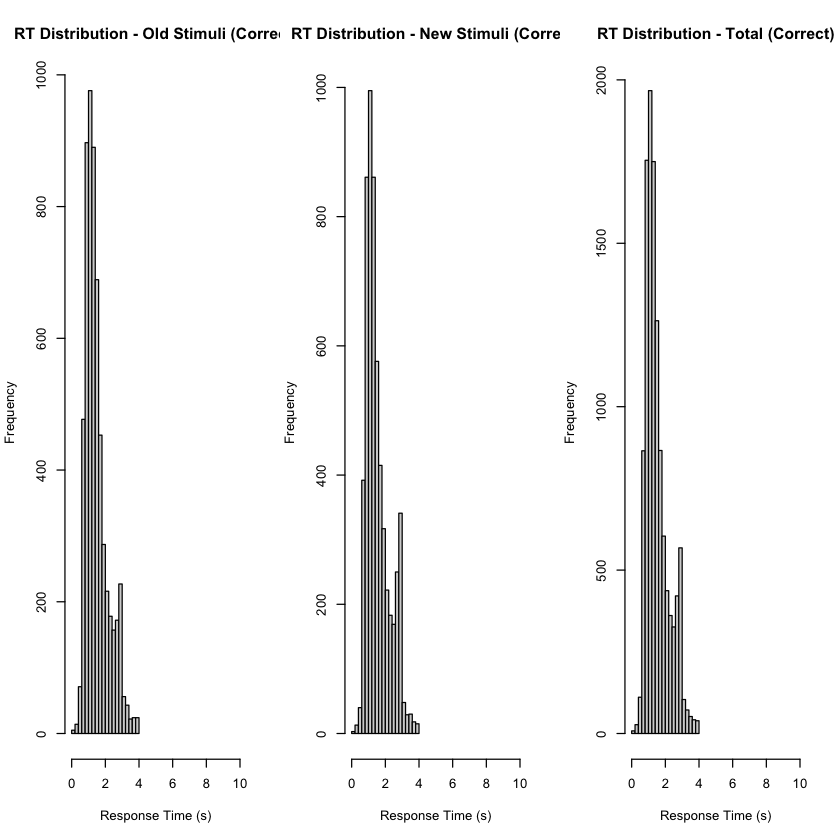

In [29]:
IRdisplay::display_html(comparison_table_rt_abs)
IRdisplay::display_html(comparison_table_rt_rel)
IRdisplay::display_html(comparison_table_rt_rel_split)

# Optional: Add RT distribution visualization
par(mfrow=c(1,3))
hist(df6$image_recall_response.rt[df6$recall_answ==1], main="RT Distribution - Old Stimuli (Correct)", 
     xlab="Response Time (s)", breaks=20, xlim=c(0,10))
hist(df5$image_recall_response.rt[df5$recall_answ==1], main="RT Distribution - New Stimuli (Correct)", 
     xlab="Response Time (s)", breaks=20, xlim=c(0,10))
hist(df_total$image_recall_response.rt[df_total$recall_answ==1], main="RT Distribution - Total (Correct)", 
     xlab="Response Time (s)", breaks=20, xlim=c(0,10))